In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score
import scipy

from loss.dilate_loss import dilate_loss

In [2]:
class GenericFF(nn.Module):
    def __init__(self, T_no, H_no, layer_no, in_no, device):
        super().__init__()
        
        self.T_no = T_no
        self.H_no = H_no
        self.layer_no = layer_no
        self.in_no = in_no
        self.device = device
        
        ### Cosine Basis ###
        self.cos_basis_no = 20
        self.cos_shift = 1
        self.cos_scale = 5
        self.cos_basis = torch.zeros(self.cos_basis_no, self.T_no).to(self.device)
        for i in range(self.cos_basis_no):
            phi = 1.5707963267948966*i
            xmin = phi - 3.141592653589793
            xmax = phi + 3.141592653589793
            
            x_in = torch.arange(self.T_no).float().to(self.device)
            raw_cos = self.cos_scale * torch.log(x_in + self.cos_shift)
            
            basis = 0.5*torch.cos(raw_cos - phi) + 0.5
            basis[raw_cos < xmin] = 0.0
            basis[raw_cos > xmax] = 0.0 
            self.cos_basis[i] = self.cos_basis[i] + basis
            
        #self.W_conv = nn.Parameter(torch.randn(self.H_no, self.in_no, self.cos_basis_no)*0.05 , requires_grad=True)
        self.W_conv = nn.Parameter(torch.randn(self.H_no, self.in_no, self.T_no)*0.05, requires_grad=True)
        
        self.ff = []
        for i in range(self.layer_no):
            if i == 0:
                self.ff.append(nn.Linear(self.H_no, self.H_no))
                #self.ff.append(nn.LeakyReLU())
                self.ff.append(nn.Tanh())
            if i == self.layer_no-1:
                self.ff.append(nn.Linear(self.H_no, 1))
        self.ff = nn.Sequential(*self.ff)
        
    def forward(self, S):
        T_data = S.shape[0]
        S_pad = torch.zeros(T_data+self.T_no-1, self.in_no).to(self.device)
        S_pad[-T_data:] = S_pad[-T_data:] + S
        S_pad = S_pad.T.unsqueeze(0)
        
        #kern = torch.matmul(self.W_conv, self.cos_basis)
        kern = self.W_conv
        kern = torch.flip(kern, [2])
        
        #S_conv = F.leaky_relu(F.conv1d(S_pad, kern).squeeze(0).T)
        S_conv = torch.tanh(F.conv1d(S_pad, kern).squeeze(0).T)
        out = self.ff(S_conv).flatten()
        
        return out

In [3]:
base_dir = "/media/hdd01/sklee/"
experiment = "clust4-60"
cell_type = "CA1"
E_neural_file = "Espikes_neural.npz"
I_neural_file = "Ispikes_neural.npz"
V_file = "V_diff.npy"
#V_file = "vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep150_stimseed1.npy"
eloc_file = "Elocs_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep150_stimseed1.npy"
iloc_file = "Ilocs_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep150_stimseed1.npy"

E_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)
I_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+I_neural_file)
V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)
#V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)[:,:50000].flatten()
V = torch.from_numpy(V)
eloc = np.load(base_dir+cell_type+"_"+experiment+"/data/"+eloc_file)
iloc = np.load(base_dir+cell_type+"_"+experiment+"/data/"+iloc_file)

den_idx = np.unique(eloc[880:1120])
e_idx = np.where(np.isin(eloc[:,0], den_idx) == True)[0]
i_idx = np.where(np.isin(iloc[:,0], den_idx) == True)[0]
e_idx = torch.from_numpy(e_idx)
i_idx = torch.from_numpy(i_idx)

In [4]:
T_train = 149 * 1000 * 50
T_test = 1 * 1000 * 50
T_no = 101
H_no = 25
layer_no = 1
in_no = e_idx.shape[0] + i_idx.shape[0]
#in_no = 2200
save_dir = base_dir+cell_type+"_"+experiment+"/"
device = torch.device("cuda")

alpha = 0.5
gamma = 0.01

batch_size = 2500
iter_no = 10000
epoch_no = iter_no*batch_size//T_train 

In [5]:
V_train = V[:T_train].float()
V_test = V[T_train:T_train + T_test].to(device).float()

test_E_neural = E_neural[T_train:T_train+T_test].toarray()
test_I_neural = I_neural[T_train:T_train+T_test].toarray()
train_E_neural = E_neural[:T_train]
train_I_neural = I_neural[:T_train]

test_E_neural = torch.from_numpy(test_E_neural).float().to(device)
test_I_neural = torch.from_numpy(test_I_neural).float().to(device)

batch_no = (T_train - batch_size) * epoch_no
train_idx = np.empty((epoch_no, T_train//batch_size))
for i in range(epoch_no):
    part_idx = np.arange(0, T_train, batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

In [6]:
model = GenericFF(T_no, H_no, layer_no, in_no, device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0025)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

775851


In [7]:
for i in tnrange(iter_no):
    model.train()
    optimizer.zero_grad()
    
    batch_idx = train_idx[i].long()
    batch_E_neural = train_E_neural[batch_idx : batch_idx+batch_size].toarray()
    batch_I_neural = train_I_neural[batch_idx : batch_idx+batch_size].toarray()
    batch_E_neural = torch.from_numpy(batch_E_neural).float().to(device)
    batch_I_neural = torch.from_numpy(batch_I_neural).float().to(device)
    batch_V = V_train[batch_idx : batch_idx+batch_size].to(device)
    
    V_pred = model(torch.hstack((batch_E_neural[:,e_idx], batch_I_neural[:,i_idx])))
    #V_pred = model(torch.hstack((batch_E_neural, batch_I_neural)))
    
    train_score = explained_variance_score(batch_V.cpu().detach().numpy(), V_pred.cpu().detach().numpy())

    #loss = torch.var(V_pred - batch_V)
    train_mse = torch.mean((V_pred - batch_V)**2)
    
    loss, loss_shape, loss_temporal = dilate_loss(batch_V.reshape(1,-1,1),
                                                  V_pred.reshape(1,-1,1),
                                                  alpha, gamma, device)
    loss.backward()
    optimizer.step()
    
    if (i%50 == 49) or (i == 0):
        model.eval()
        test_V_pred = model(torch.hstack((test_E_neural[:,e_idx], test_I_neural[:,i_idx])))
        #test_V_pred = model(torch.hstack((test_E_neural, test_I_neural)))
                 
        test_score = explained_variance_score(V_test.cpu().detach().numpy(), test_V_pred.cpu().detach().numpy())
        test_mse = torch.mean((V_test-test_V_pred)**2).item()
        
        print(i, test_score, test_mse, train_score, train_mse.item())


<ipython-input-7-ea65001d5eb0>:1: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


0 -0.03734326362609863 0.0420602448284626 -65878.984375 0.008766552433371544
49 0.06299698352813721 0.02657448872923851 -327821.40625 0.00040808733319863677
99 0.12164163589477539 0.023930365219712257 -59120.671875 0.0010358636500313878
149 0.11348092555999756 0.024110902100801468 -290461.375 0.0009757818188518286
199 0.11220061779022217 0.024182181805372238 -8929.4267578125 0.0009969740640372038
249 0.12816447019577026 0.023711351677775383 0.11221706867218018 0.02174070104956627
299 0.12222522497177124 0.02404218725860119 0.025179266929626465 0.14094938337802887
349 0.11380904912948608 0.02411266788840294 -639812.6875 0.001929486752487719
399 0.11602890491485596 0.024042684584856033 -2695077.5 0.001454496174119413
449 0.12074553966522217 0.02397070825099945 -233730.96875 0.0020829886198043823



KeyboardInterrupt: 

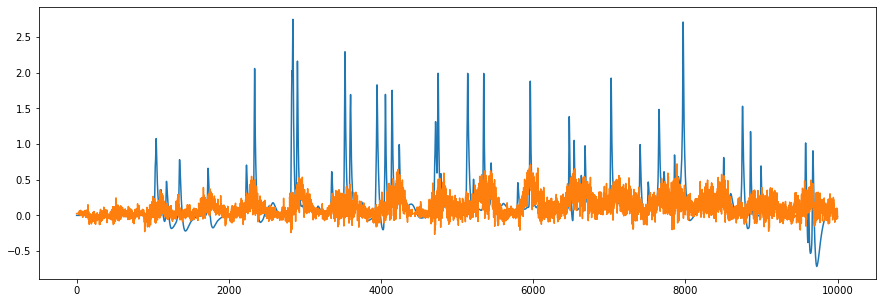

In [8]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy()[16000:26000])
plt.plot(test_V_pred.cpu().detach().numpy()[16000:26000])

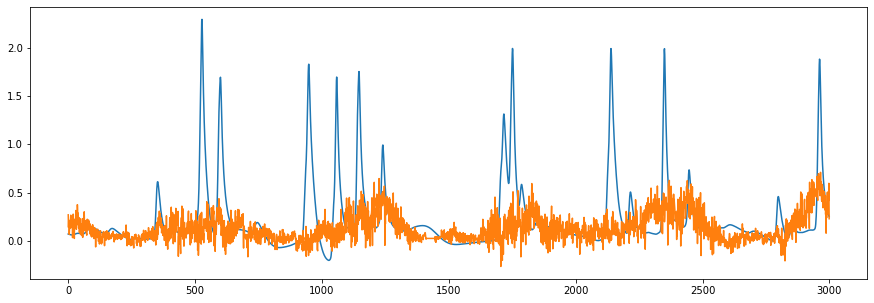

In [9]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy()[16000:26000][3000:6000])
plt.plot(test_V_pred.cpu().detach().numpy()[16000:26000][3000:6000])

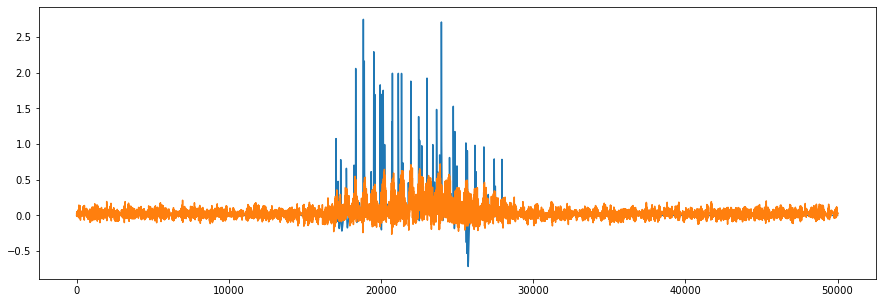

In [10]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy())
plt.plot(test_V_pred.cpu().detach().numpy())